- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
- Model inspiration : [link](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [8]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [9]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation
- Import usefull lib
- Define Np. and Tf. random 
- Config mathplot

In [10]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"


# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# Step 2: load the data
- Load the Cifar10 dataset directly from keras.datasets
- Define train data and test data

In [11]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


# Step : Data preparation
- Split train data into 80/20 ratio => 80% training 20% validation
  - New X data : X_train_new, X_val, X_test
  - New Y data : y_train_new, y_val, y_test
- Hot encode labels for Y data
- Format and normalize X data
- Define class name for Y data

In [12]:
# Create the validation set from the train set
# Take 20% (0.2) of the total set (50000 * 0.2 = 10000 record)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# One hot encode target values
y_train_new = tf.keras.utils.to_categorical(y_train_new, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Format in float32 and normalize to [0,1]
X_train_new = X_train_new.astype('float32') / 255.0
X_val       = X_val.astype('float32') / 255.0
X_test      = X_test.astype('float32') / 255.0

# Define class name
classNames = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']




# Step : Display data and stuff
- Display Y data shape
- Display Y data hot encoding
- Display the 10 first image with label

(40000, 10)
(10000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


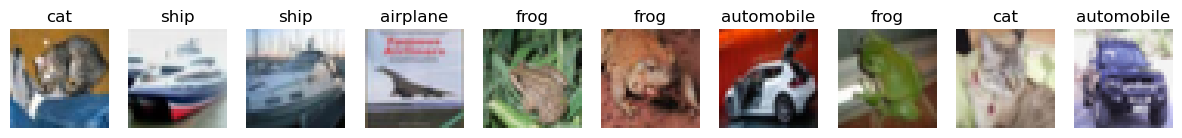

In [13]:
print(y_train_new.shape)
print(y_val.shape)
print(y_test.shape)

print(y_train_new[0])
print(y_val[0])
print(y_test[0])

fig, ax = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    ax[i].axis('off')
    cls_idx = np.argmax(y_test[i])
    ax[i].set_title(classNames[cls_idx])
    ax[i].imshow(X_test[i])
plt.show()

# Step : Define models

```bash
## Small : Start simple
- Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
- Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
- Layer 3 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

## Medium : Add 1 layer with 2 x Conv 128
- Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
- Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
- Layer 3 : 2 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
- Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

## Large : Add 1 Conv in each layer
- Layer 1 : 3 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
- Layer 2 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
- Layer 3 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
- Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

## X-Large : Double filters on each layer + adapte dense layer to match
- Layer 1 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
- Layer 2 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
- Layer 3 : 3 x (Conv 256 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
- Layer 4 : Flatten + Dense 256 + BatchNorm + Dropout(0.5) + Dense soft max



In [ ]:
def create_model(model_name="small"):
    if model_name == "small":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "medium":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "X_large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


# Step : Define optimizers
- Adam with LR 0.001

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


2025-09-22 08:11:49.556498: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-09-22 08:11:49.556536: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-09-22 08:11:49.556552: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-09-22 08:11:49.556582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-22 08:11:49.556602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Step : Compile and display the model
- Create model from template Small
- Compile model
  - Loss not set to spark_ because of hot encoding
- Display the model architecture

In [16]:

model = create_model("small") 
model.compile(loss="categorical_crossentropy",
              optimizer=opt, 
              metrics=['accuracy'])
# Show model shape
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

# Step : Preprocess for training
- Define batch size
- Define train_ds using tensor_slices
  - Use shuffle
  - Use prefectch
- Define val_ds same as before
  - Don't use shuffle
  - Use prefectch

In [17]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train the small model
- Train the model using train_ds and val_ds
- Store the history in `history_small` for later plotting

In [18]:
history_small = model.fit(train_ds, epochs=1, validation_data=val_ds)

2025-09-22 08:11:51.677952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.4670 - loss: 1.5924 - val_accuracy: 0.6226 - val_loss: 1.0724


# Step : Define Plot function
- The function will plot 2 graphs, one for the Accuracy and one for the Lost
- As a function so we can reuse it later

In [19]:

def plot_result(history):
    # Create subplots for Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Step : Run plot results function

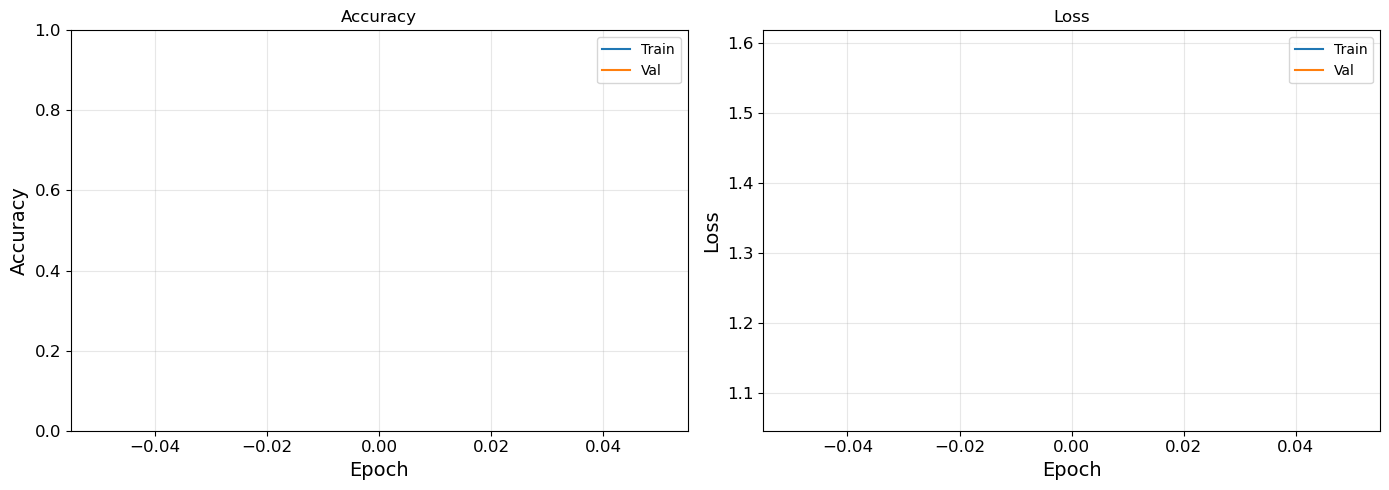

In [20]:
plot_result(history_small)

# Step : Define Evaluation function
- The function will : 
  - Do a accuracy test using `model.predict`
  - Do a confusion Matrix from that predict
  - Do a classification report from that predict
- As a function so we can reuse it later

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def evaluate_and_report(model, X_test, y_test, class_names, batch_size=256):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    y_prob = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return {
        "accuracy": test_acc,
        "loss": test_loss
    }

# Step : Run Evaluation function

Test Accuracy: 0.6205



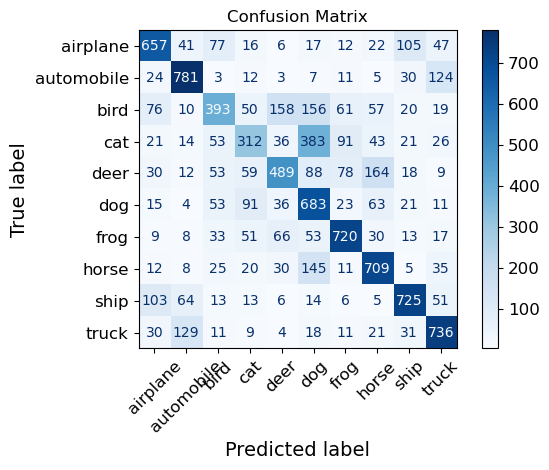

Classification Report:

              precision    recall  f1-score   support

    airplane       0.67      0.66      0.66      1000
  automobile       0.73      0.78      0.75      1000
        bird       0.55      0.39      0.46      1000
         cat       0.49      0.31      0.38      1000
        deer       0.59      0.49      0.53      1000
         dog       0.44      0.68      0.53      1000
        frog       0.70      0.72      0.71      1000
       horse       0.63      0.71      0.67      1000
        ship       0.73      0.72      0.73      1000
       truck       0.68      0.74      0.71      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.61     10000
weighted avg       0.62      0.62      0.61     10000



{'accuracy': 0.6205000281333923, 'loss': 1.0801295042037964}

In [22]:
evaluate_and_report(model, X_test, y_test, class_names=classNames)

# Step : Define generic Class train and evaluate
- Define `train_model` function
  - Try to resume from the last best weight
  - Try to resume from the last best model
  - If nothing work train from scratch
  - Create model from template Small
  - Compile model
  - Display the model architecture
  - Train `model.fit`
  - Save model and history
- Define `load_best_weight` function
  - Just a helper function to load the weight
- Define `evaluate_model` function
  - Wrap previous plot and evaluation function
  - Save to file metrics
- Define `run` function
  - Pipeline to Train and Evaluate Model

In [ ]:
import json
import tensorflow as tf
from types import SimpleNamespace

class TrainAndEvaluateModel:
    def __init__(self, model_name=None,
                 train_ds=None, 
                 val_ds=None,
                 optimizer=None, 
                 loss_fn=None, 
                 epochs=5,
                 callbacks=None,
                 X_test=None, 
                 y_test=None, 
                 class_names=None,
                 force=False,
                 model_summary=False,
                 base_dir="saved_models"
                 ):
        
        self.model_name = model_name
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.callbacks = callbacks
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.force = force
        self.model_summary = model_summary

        self.save_dir = os.path.join(base_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        self.save_path = os.path.join(self.save_dir, f"{self.model_name}_model.keras")
        self.history_path = os.path.join(self.save_dir, f"{self.model_name}_history.json")
        self.metrics_path = os.path.join(self.save_dir, f"{self.model_name}_metrics.json")
        self.best_weights_path = os.path.join(self.save_dir, "best_model.weights.h5")

        self.model = None
        self.history = None
        self.metrics = None

    def train_model(self):
        # Resume from best weights if they exist
        if os.path.exists(self.best_weights_path) and not self.force:
            print(f"Resuming from best checkpoint: {self.best_weights_path}")
            self.model = create_model(self.model_name)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            self.model.load_weights(self.best_weights_path)

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Resume from last full model
        elif os.path.exists(self.save_path) and not self.force:
            print(f"Loading last trained model: {self.save_path}")
            self.model = tf.keras.models.load_model(self.save_path)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        # Train from scratch
        else:
            if self.force:
                print(f"Forcing retrain for model: {self.model_name}")
            else:
                print(f"Training new model: {self.model_name}")

            self.model = create_model(self.model_name)
            self.model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            if self.model_summary:
                print(f"Summary for model: {self.model_name}")
                self.model.summary()
            else:
                print("Summary disabled")

            fit_kwargs = {
                "x": self.train_ds,
                "epochs": self.epochs,
                "verbose": 1,
                "validation_data": self.val_ds
            }
            # only if callbacks is defined
            if self.callbacks is not None:
                fit_kwargs["callbacks"] = self.callbacks

            self.history = self.model.fit(**fit_kwargs)

            # Save last full model
            self.model.save(self.save_path)
            print(f"Last model saved to {self.save_path}")

            with open(self.history_path, "w") as f:
                json.dump(self.history.history, f)
            print(f"History saved to {self.history_path}")

        return self.model, self.history

    def load_best_weights(self):
        if os.path.exists(self.best_weights_path):
            print(f"Loading best weights from {self.best_weights_path}")
            best_model = create_model(self.model_name)
            best_model.compile(
                loss=self.loss_fn,
                optimizer=self.optimizer,
                metrics=['accuracy']
            )
            best_model.load_weights(self.best_weights_path)
            self.model = best_model
        else:
            print("No best_model.weights.h5 found, using current model.")

    def evaluate_model(self):
        if self.history is not None:
            plot_result(self.history)

        self.metrics = evaluate_and_report(
            self.model,
            self.X_test,
            self.y_test,
            class_names=self.class_names
        )

        with open(self.metrics_path, "w") as f:
            json.dump(self.metrics, f)
        print(f"Metrics saved to {self.metrics_path}")

        return self.metrics

    def run(self):
        self.train_model()
        self.load_best_weights()
        self.evaluate_model()
        return {
            "model": self.model,
            "history": self.history,
            "metrics": self.metrics
        }


# Step : Use Class train and evaluate
- Define a list of models archtecture to use
- Define a empty list of results `results`
- For each models in the list train and evaluate then store in the `results` list

Training model: small
Loading last trained model: saved_models/results/small/small_model.keras
⚠️ No best_model.weights.h5 found, using current model.


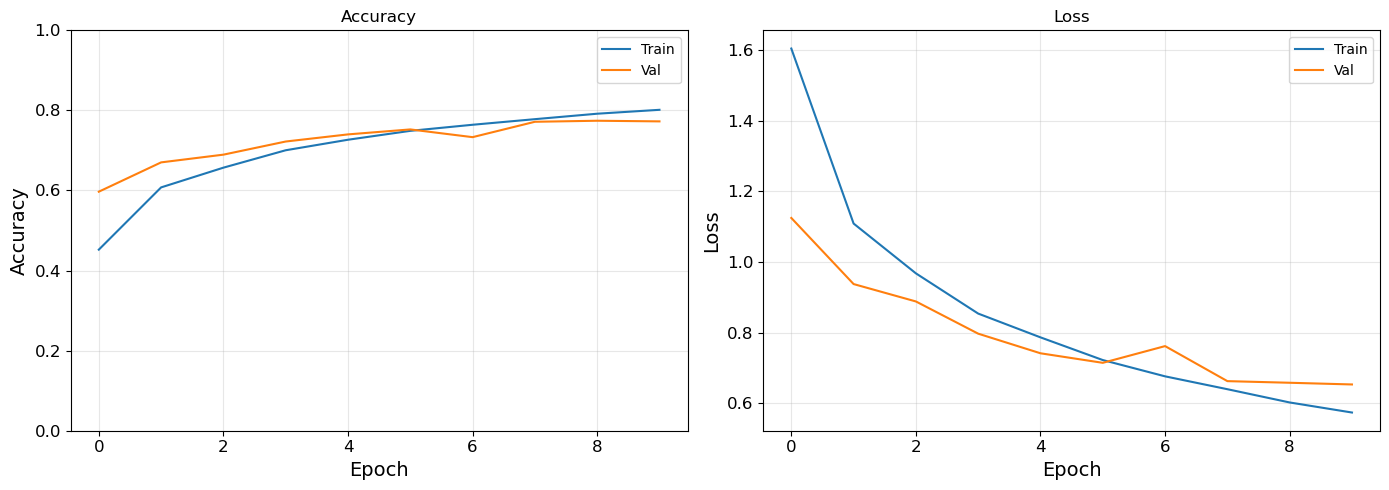

Test Accuracy: 0.7731



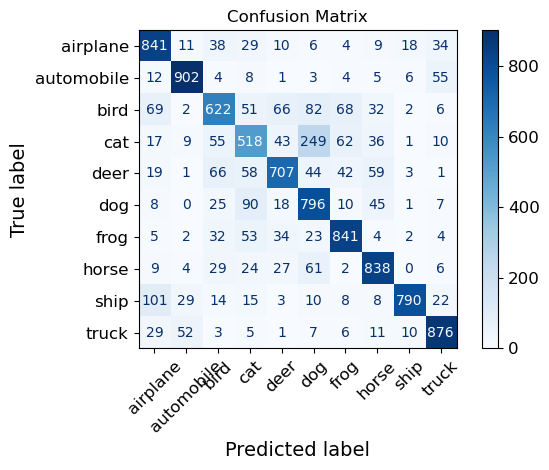

Classification Report:

              precision    recall  f1-score   support

    airplane       0.76      0.84      0.80      1000
  automobile       0.89      0.90      0.90      1000
        bird       0.70      0.62      0.66      1000
         cat       0.61      0.52      0.56      1000
        deer       0.78      0.71      0.74      1000
         dog       0.62      0.80      0.70      1000
        frog       0.80      0.84      0.82      1000
       horse       0.80      0.84      0.82      1000
        ship       0.95      0.79      0.86      1000
       truck       0.86      0.88      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

✅ Metrics saved to saved_models/results/small/small_metrics.json
Training model: medium
Loading last trained model: saved_models/results/medium/medium_model.keras
⚠️ No best_model.weights.h5 found, using current model

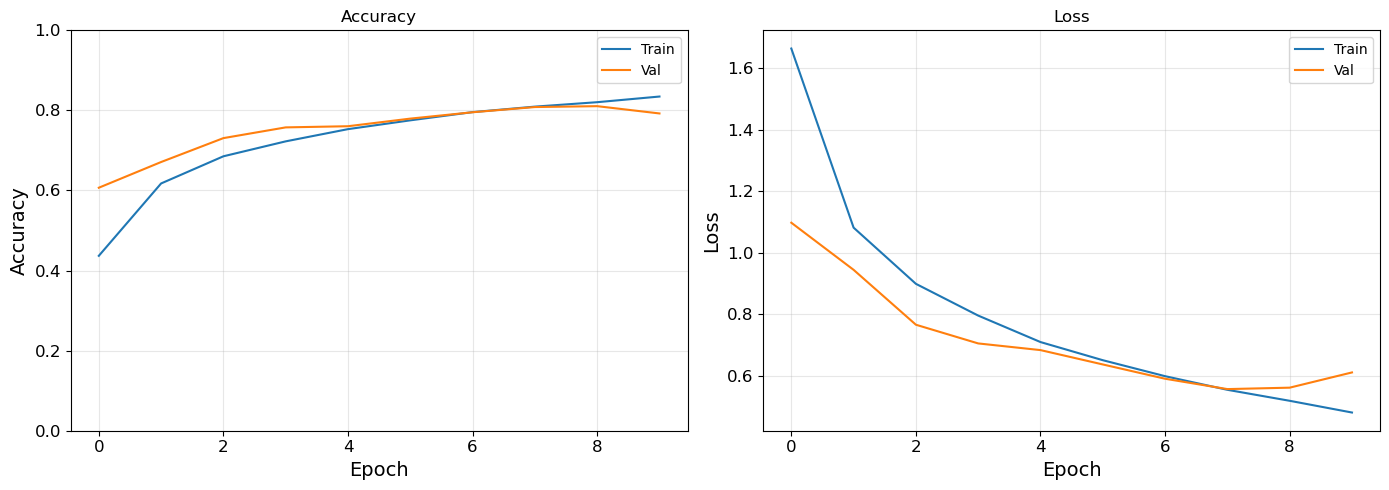

Test Accuracy: 0.7890



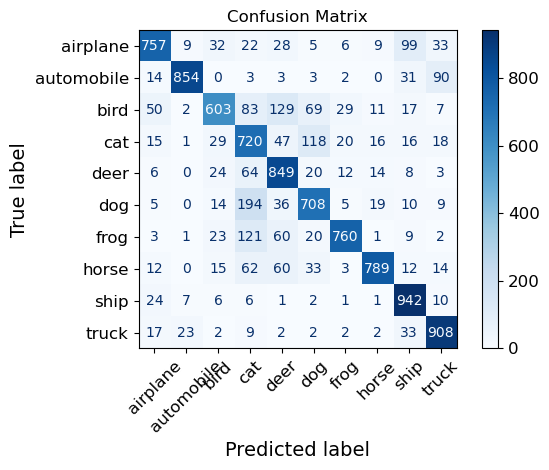

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.76      0.80      1000
  automobile       0.95      0.85      0.90      1000
        bird       0.81      0.60      0.69      1000
         cat       0.56      0.72      0.63      1000
        deer       0.70      0.85      0.77      1000
         dog       0.72      0.71      0.72      1000
        frog       0.90      0.76      0.83      1000
       horse       0.92      0.79      0.85      1000
        ship       0.80      0.94      0.87      1000
       truck       0.83      0.91      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

✅ Metrics saved to saved_models/results/medium/medium_metrics.json
Training model: large
Loading last trained model: saved_models/results/large/large_model.keras
⚠️ No best_model.weights.h5 found, using current model.

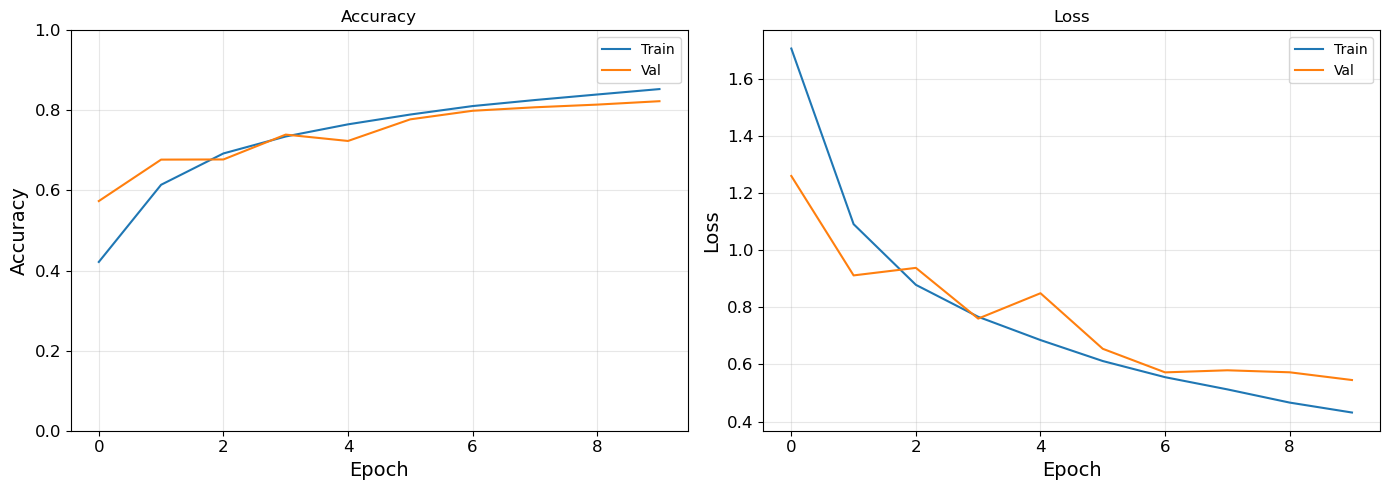

Test Accuracy: 0.8191



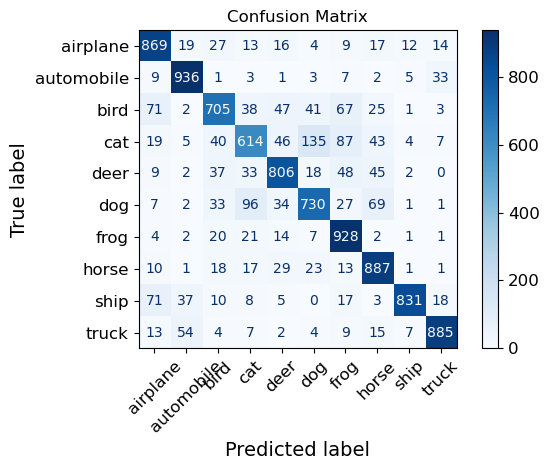

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.87      0.83      1000
  automobile       0.88      0.94      0.91      1000
        bird       0.79      0.70      0.74      1000
         cat       0.72      0.61      0.66      1000
        deer       0.81      0.81      0.81      1000
         dog       0.76      0.73      0.74      1000
        frog       0.77      0.93      0.84      1000
       horse       0.80      0.89      0.84      1000
        ship       0.96      0.83      0.89      1000
       truck       0.92      0.89      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

✅ Metrics saved to saved_models/results/large/large_metrics.json
Training model: X_large
Loading last trained model: saved_models/results/X_large/X_large_model.keras
⚠️ No best_model.weights.h5 found, using current mo

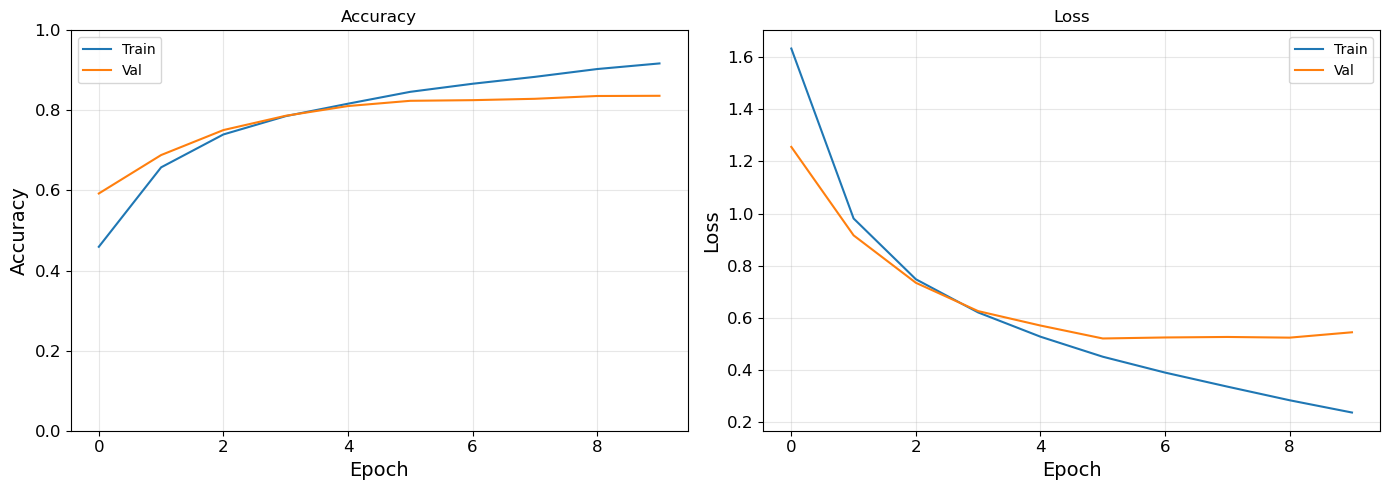

Test Accuracy: 0.8296



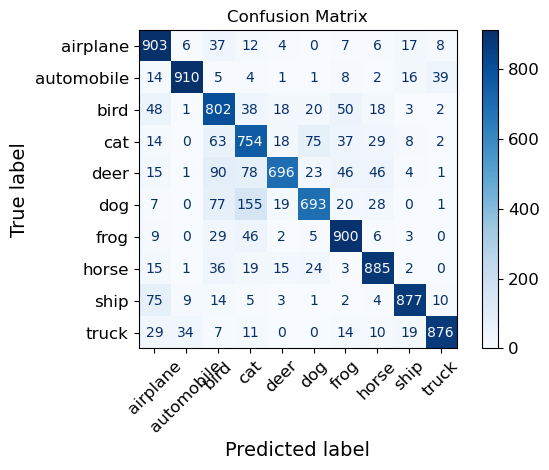

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.90      0.85      1000
  automobile       0.95      0.91      0.93      1000
        bird       0.69      0.80      0.74      1000
         cat       0.67      0.75      0.71      1000
        deer       0.90      0.70      0.78      1000
         dog       0.82      0.69      0.75      1000
        frog       0.83      0.90      0.86      1000
       horse       0.86      0.89      0.87      1000
        ship       0.92      0.88      0.90      1000
       truck       0.93      0.88      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

✅ Metrics saved to saved_models/results/X_large/X_large_metrics.json


In [24]:
model_names = ["small", "medium", "large", "X_large"]
results = {}

for name in model_names:
    print(f"Training model: {name}")
    
    trainer = TrainAndEvaluateModel(
        model_name=name,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=tf.keras.optimizers.Adam(),
        loss_fn="categorical_crossentropy",
        epochs=10,
        X_test=X_test,
        y_test=y_test,
        class_names=classNames,
        force=False,
        base_dir="saved_models/results"
    )

    results[name] = trainer.run()


# Step : Compare models accuracy
- For each models in `results` show the accuracy

In [25]:
for name, result in results.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")



small           | Test Accuracy: 0.7731
medium          | Test Accuracy: 0.7890
large           | Test Accuracy: 0.8191
X_large         | Test Accuracy: 0.8296


# Step : Add callback function

After the first run of each model, we can see that many could have been stop earlier. Also reducing the LR over time could help to improve the model. And lastly, we want to save the best weight found during the train.

- `get_callbacks` : ReduceLROnPlateau with patience of 3 epochs
- `checkpoint_cb` : To save the best weight found
- `earlystop_cb` : To stop the model if it has stopped to progress, we wait 5 epochs

In [26]:

def get_callbacks(save_dir):
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-9
    )

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_dir, "best_model.weights.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    earlystop_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=False,
        verbose=1
    )

    return [lr_scheduler, checkpoint_cb, earlystop_cb]


# Step : Add simple data augmentation
- By changing a bit each image for the train, it could help to prevent overfitting
  - Flip the image horizontaly
  - Translate the image randomly

In [27]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

# Step : Update Preprocess for training
- Plug the augmentation step in the previous train_ds generator
- `.map(lambda x, y: (augment(x, training=True), y),` 

In [28]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(lambda x, y: (augment(x, training=True), y),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train with data augmentation
- Using the same loop training as before
- This time we also give the callback function as parameter
- Change the result variable to `results2`

Training model: small
Resuming from best checkpoint: saved_models/results2/small/best_model.weights.h5
Loading best weights from saved_models/results2/small/best_model.weights.h5


/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


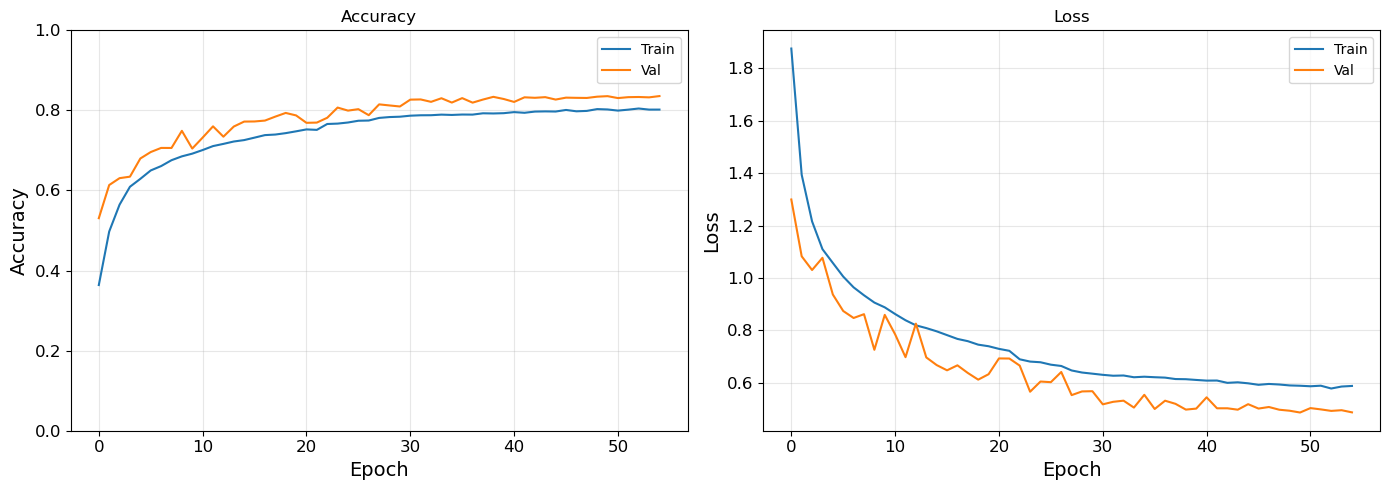

Test Accuracy: 0.8339



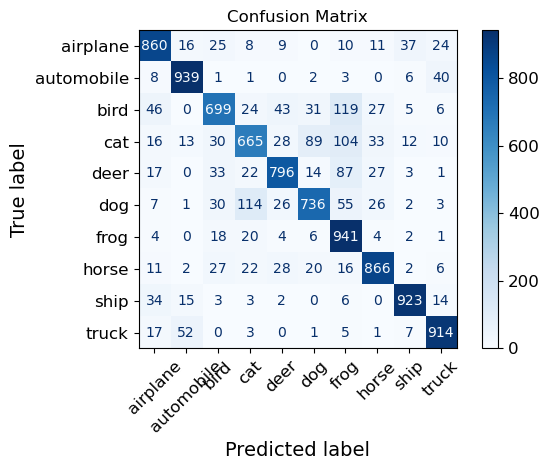

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.81      0.70      0.75      1000
         cat       0.75      0.67      0.71      1000
        deer       0.85      0.80      0.82      1000
         dog       0.82      0.74      0.78      1000
        frog       0.70      0.94      0.80      1000
       horse       0.87      0.87      0.87      1000
        ship       0.92      0.92      0.92      1000
       truck       0.90      0.91      0.91      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

✅ Metrics saved to saved_models/results2/small/small_metrics.json
Training model: medium
Resuming from best checkpoint: saved_models/results2/medium/best_model.weights.h5
Loading best weights from saved_models/results

/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


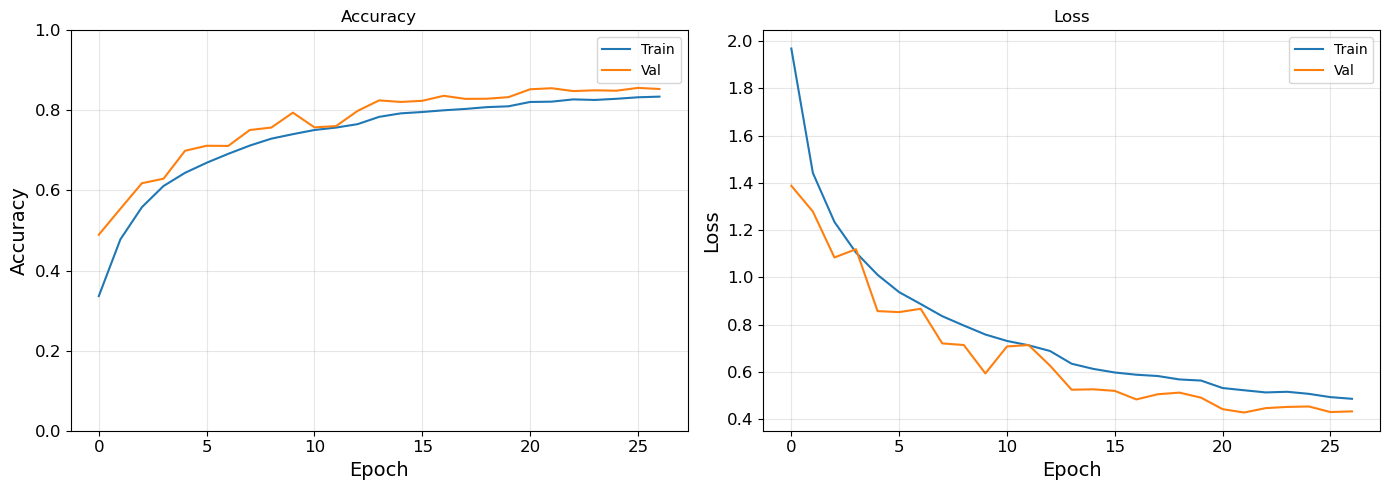

Test Accuracy: 0.8508



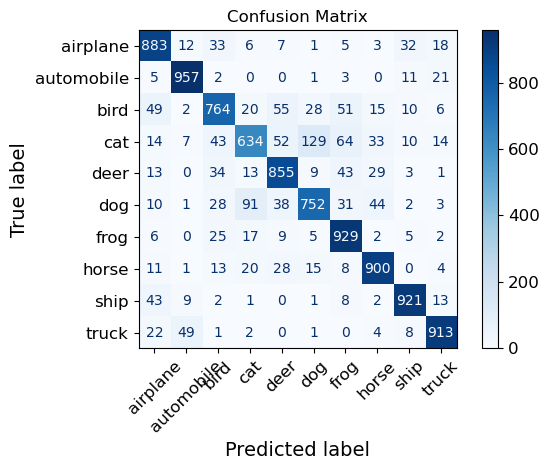

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.88      0.86      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.81      0.76      0.79      1000
         cat       0.79      0.63      0.70      1000
        deer       0.82      0.85      0.84      1000
         dog       0.80      0.75      0.77      1000
        frog       0.81      0.93      0.87      1000
       horse       0.87      0.90      0.89      1000
        ship       0.92      0.92      0.92      1000
       truck       0.92      0.91      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

✅ Metrics saved to saved_models/results2/medium/medium_metrics.json
Training model: large
Resuming from best checkpoint: saved_models/results2/large/best_model.weights.h5
Loading best weights from saved_models/results

/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 86 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


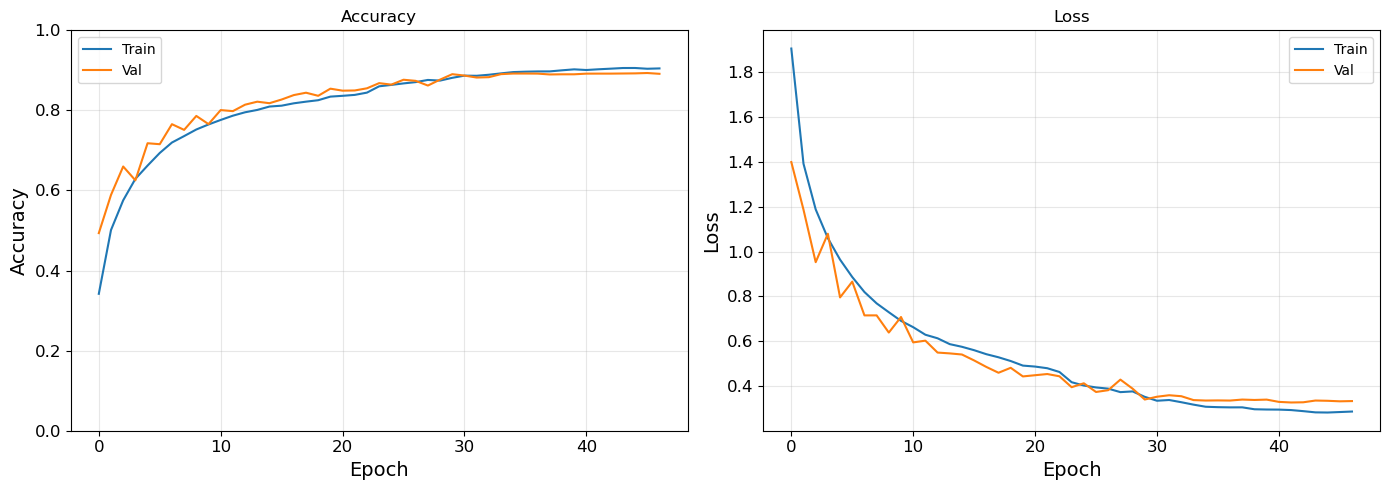

Test Accuracy: 0.8906



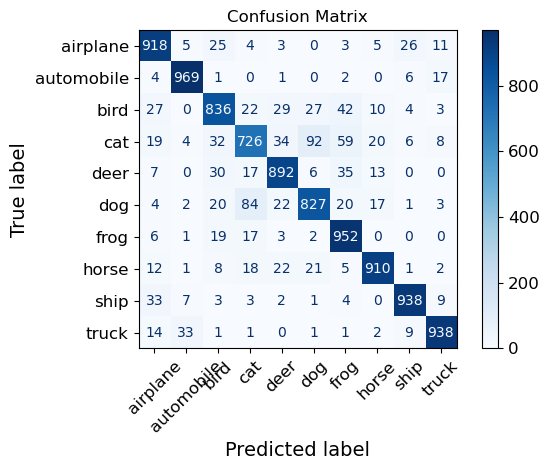

Classification Report:

              precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.86      0.84      0.85      1000
         cat       0.81      0.73      0.77      1000
        deer       0.88      0.89      0.89      1000
         dog       0.85      0.83      0.84      1000
        frog       0.85      0.95      0.90      1000
       horse       0.93      0.91      0.92      1000
        ship       0.95      0.94      0.94      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

✅ Metrics saved to saved_models/results2/large/large_metrics.json
Training model: X_large
Resuming from best checkpoint: saved_models/results2/X_large/best_model.weights.h5
Loading best weights from saved_models/resul

/Users/homer/_mygit/cas-aml/_Miniforge/install_dir/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 86 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


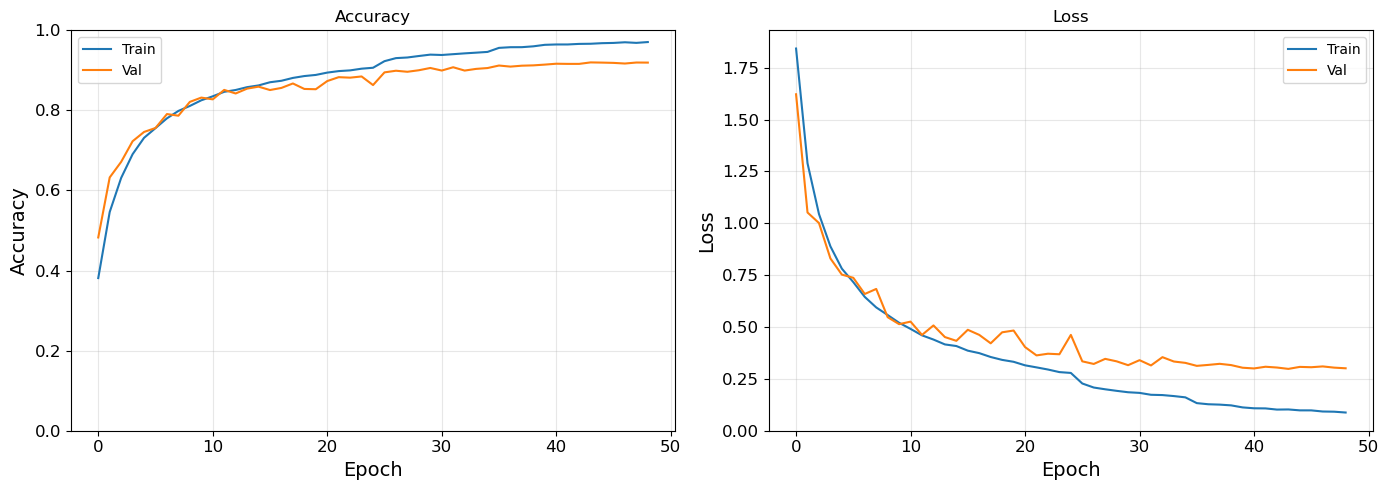

Test Accuracy: 0.9183



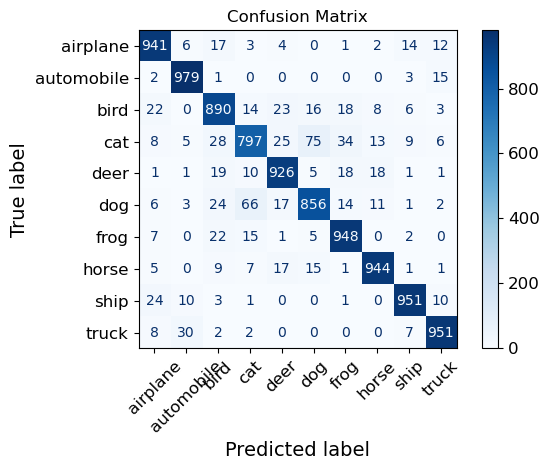

Classification Report:

              precision    recall  f1-score   support

    airplane       0.92      0.94      0.93      1000
  automobile       0.95      0.98      0.96      1000
        bird       0.88      0.89      0.88      1000
         cat       0.87      0.80      0.83      1000
        deer       0.91      0.93      0.92      1000
         dog       0.88      0.86      0.87      1000
        frog       0.92      0.95      0.93      1000
       horse       0.95      0.94      0.95      1000
        ship       0.96      0.95      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

✅ Metrics saved to saved_models/results2/X_large/X_large_metrics.json


In [29]:
results2 = {}

for name in model_names:
    print(f"Training model: {name}")

    save_dir = os.path.join("saved_models", "results2", name)
    os.makedirs(save_dir, exist_ok=True)

    callbacks = get_callbacks(save_dir)
    
    trainer = TrainAndEvaluateModel(
        model_name=name,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=tf.keras.optimizers.Adam(),
        loss_fn="categorical_crossentropy",
        epochs=200,
        callbacks=callbacks,
        X_test=X_test,
        y_test=y_test,
        class_names=classNames,
        force=False,
        base_dir="saved_models/results2"
    )

    results2[name] = trainer.run()


In [30]:
for name, result in results.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")

for name, result in results2.items():
    acc = result["metrics"]["accuracy"]
    print(f"{name:<15} | Test Accuracy: {acc:.4f}")



small           | Test Accuracy: 0.7731
medium          | Test Accuracy: 0.7890
large           | Test Accuracy: 0.8191
X_large         | Test Accuracy: 0.8296
small           | Test Accuracy: 0.8339
medium          | Test Accuracy: 0.8508
large           | Test Accuracy: 0.8906
X_large         | Test Accuracy: 0.9183


# Step : Grid search

There is plenty of possibility to improve the accuracy
- More dropout
- More layer
- Denser layer
- LR
- LR patience
- L2 regularization
- Batch size
- etc.

To speed up the test of each possiblity we use a grid search.

Grid search will try all the combinaison from a set or possibility.

To test if the LR 0.001 or 0.0001 is better and if more filter could help we define a list of possible parameter as `param_grid`

```bash

param_grid = {
    "dropout_rates": [
        {"block1":0.1, "block2":0.2, "block3":0.3, "dense":0.5}
    ],
    "optimizer": ["adam","SDG"],
    "lr": [5e-2,5e-3],
    "batch_size": [32,64],
    "lr_patience": [2,5],
    "min_lr": [1e-7],
    "L2": [None,1e-4] 
}

```

# Step : Define tunable model

- Because the 2 best have the same architecture and only the number of parameter per convolution change. We define a tunable model as follow.
- We add also the regularization into each conv layer and the final dense one
- We define variable where we want to have the opportunnity to Grid search it

In [31]:
def create_flexible_model(filters=(32, 64, 128), 
                          dense_units=128,
                          dropout_rates=None,
                          L2=None):
    
    if dropout_rates is None:
        dropout_rates = {"block1": 0.1, "block2": 0.2, "block3": 0.3, "dense": 0.5}

    wreg = tf.keras.regularizers.l2(L2) if L2 is not None else None

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),

        # Block 1
        tf.keras.layers.Conv2D(filters[0], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[0], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[0], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(dropout_rates["block1"]),

        # Block 2
        tf.keras.layers.Conv2D(filters[1], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[1], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[1], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(dropout_rates["block2"]),

        # Block 3
        tf.keras.layers.Conv2D(filters[2], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[2], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[2], 3, padding="same", activation="relu",
                               kernel_initializer='he_uniform', kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(dropout_rates["block3"]),

        # Dense head
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation="relu", 
                              kernel_regularizer=wreg),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rates["dense"]),
        tf.keras.layers.Dense(10, activation="softmax", 
                              kernel_regularizer=wreg)
    ])

    return model


# Step : Define new TrainAndEvaluationModel Class
- Update the code to support the new parameter that grid search could pass

In [ ]:
import os
import json
import tensorflow as tf
from types import SimpleNamespace

class TrainAndEvaluateModel:
    def __init__(self, model_name="flexible",
                 train_ds=None, 
                 val_ds=None,
                 optimizer=None, 
                 loss_fn=None, 
                 epochs=5,
                 callbacks=None,
                 X_test=None, 
                 y_test=None, 
                 class_names=None,
                 filters=(32, 64, 128),
                 dense_units=128,
                 dropout_rates=None,
                 L2=None,
                 force=False,
                 model_summary=False,
                 base_dir="saved_models"
                 ):
        
        self.model_name = model_name
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.callbacks = callbacks
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.filters = filters
        self.dense_units = dense_units
        self.dropout_rates = dropout_rates
        self.L2 = L2
        self.force = force
        self.model_summary = model_summary

        self.save_dir = os.path.join(base_dir, self.model_name)
        os.makedirs(self.save_dir, exist_ok=True)

        # Paths
        self.save_path = os.path.join(self.save_dir, f"{self.model_name}_model.keras")
        self.history_path = os.path.join(self.save_dir, f"{self.model_name}_history.json")
        self.metrics_path = os.path.join(self.save_dir, f"{self.model_name}_metrics.json")
        self.best_weights_path = os.path.join(self.save_dir, "best_model.weights.h5")

        self.model = None
        self.history = None
        self.metrics = None

    def train_model(self):
        if os.path.exists(self.best_weights_path) and not self.force:
            print(f"Resuming from best checkpoint: {self.best_weights_path}")
            self.model = create_flexible_model(
                filters=self.filters,
                dense_units=self.dense_units,
                dropout_rates=self.dropout_rates,
                L2=self.L2
            )
            self.model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
            self.model.load_weights(self.best_weights_path)

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        elif os.path.exists(self.save_path) and not self.force:
            print(f"Loading last trained model: {self.save_path}")
            self.model = tf.keras.models.load_model(self.save_path)
            self.model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])

            if os.path.exists(self.history_path):
                with open(self.history_path, "r") as f:
                    loaded_history = json.load(f)
                self.history = SimpleNamespace(history=loaded_history)
            else:
                self.history = None

        else:
            if self.force:
                print(f"Forcing retrain for model: {self.model_name}")
            else:
                print(f"Training new model: {self.model_name}")

            self.model = create_flexible_model(
                filters=self.filters,
                dense_units=self.dense_units,
                dropout_rates=self.dropout_rates,
                L2=self.L2
            )
            self.model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])

            if self.model_summary:
                print(f"Summary for model: {self.model_name}")
                self.model.summary()
            else:
                print("Summary disabled")

            fit_kwargs = {
                "x": self.train_ds,
                "epochs": self.epochs,
                "verbose": 1,
                "validation_data": self.val_ds
            }
            if self.callbacks is not None:
                fit_kwargs["callbacks"] = self.callbacks

            self.history = self.model.fit(**fit_kwargs)

            self.model.save(self.save_path)
            print(f"Last model saved to {self.save_path}")

            with open(self.history_path, "w") as f:
                json.dump(self.history.history, f)
            print(f"History saved to {self.history_path}")

        return self.model, self.history

    def load_best_weights(self):
        if os.path.exists(self.best_weights_path):
            print(f"Loading best weights from {self.best_weights_path}")
            best_model = create_flexible_model(
                filters=self.filters,
                dense_units=self.dense_units,
                dropout_rates=self.dropout_rates,
                L2=self.L2
            )
            best_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
            best_model.load_weights(self.best_weights_path)
            self.model = best_model
        else:
            print("No best_model.weights.h5 found, using current model.")

    def evaluate_model(self):
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        metrics = {"test_loss": float(test_loss), "test_accuracy": float(test_acc)}

        self.metrics = metrics

        with open(self.metrics_path, "w") as f:
            json.dump(self.metrics, f)
        print(f"Metrics saved to {self.metrics_path}")

        return self.metrics

    def run(self):
        self.train_model()
        self.load_best_weights()
        self.evaluate_model()
        return {
            "model": self.model,
            "history": self.history,
            "metrics": self.metrics
        }


In [40]:
def _exp_name_from_params(p):
    f1, f2, f3 = p["filters"]
    dr = p["dropout_rates"]

    def _fmt_lr(x):
        try:
            return f"{float(x):.0e}" if float(x) < 1e-2 else str(x).replace('.', 'p')
        except Exception:
            return str(x).replace('.', 'p')

    if p.get("L2") is None:
        l2_tag = "none"
    else:
        try:
            l2_tag = f"{float(p['L2']):.0e}"
        except Exception:
            l2_tag = str(p['L2']).replace('.', 'p')

    return (
        f"f{f1}-{f2}-{f3}"
        f"__dense{p['dense_units']}"
        f"__dr{dr['block1']}-{dr['block2']}-{dr['block3']}-{dr['dense']}"
        f"__opt{_opt_tag(p)}"
        f"__lr{_fmt_lr(p['lr'])}"
        f"__bs{p['batch_size']}"
        f"__lrp{p['lr_patience']}"
        f"__minlr{_fmt_lr(p['min_lr'])}"
        f"__L2{l2_tag}"
    ).replace('.', '')

def _opt_tag(p):
    opt = p.get("optimizer", "adam")
    if isinstance(opt, str):
        return opt
    elif hasattr(opt, '__name__'):
        return opt.__name__
    else:
        return str(opt)
    
def _build_optimizer(params):
    name = params.get("optimizer", "adam").lower()
    lr = params.get("lr", 1e-3)

    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif name == "sgd":
        momentum = params.get("momentum", 0.9)
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    elif name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif name == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    else:
        raise ValueError(f"Unknown optimizer: {name}")




# Step : Define the param for the search and the range
- This a already iterated search where some are single value because previous run doesn't show any significant change. So this is "best value"

In [50]:
param_grid = {
    "filters": [
        (64, 128, 256) # like "X_large"

    ],
    "dense_units": [256],
    "dropout_rates": [
        {"block1":0.1, "block2":0.2, "block3":0.3, "dense":0.5},
        {"block1":0.05, "block2":0.1, "block3":0.15, "dense":0.25}
    ],
    "optimizer": ["adam"],
    "lr": [5e-3,1e-4],
    "batch_size": [64],
    "lr_patience": [5],
    "min_lr": [1e-7],
    "L2": [None] 
}


# Step : Improve data augmentation
- Replace simple augmentation by cutmix
- Cut mix take 2 images, cut a piece of one and paste it in the second.
- Also the label are mixed (40% dog + 60% cat)
- This could help with similar classes like dog cat deer etc.

In [51]:
def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    W = tf.shape(images)[1]
    H = tf.shape(images)[2]

    labels = tf.cast(labels, tf.float32)

    lam = tf.random.gamma([], alpha, 1.0)
    lam = lam / (lam + tf.random.gamma([], alpha, 1.0))
    lam = tf.cast(lam, tf.float32)

    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    rx = tf.random.uniform([], 0, W, dtype=tf.int32)
    ry = tf.random.uniform([], 0, H, dtype=tf.int32)
    rw = tf.cast(tf.cast(W, tf.float32) * tf.math.sqrt(1. - lam), tf.int32)
    rh = tf.cast(tf.cast(H, tf.float32) * tf.math.sqrt(1. - lam), tf.int32)

    x1 = tf.clip_by_value(rx - rw // 2, 0, W)
    y1 = tf.clip_by_value(ry - rh // 2, 0, H)
    x2 = tf.clip_by_value(rx + rw // 2, 0, W)
    y2 = tf.clip_by_value(ry + rh // 2, 0, H)

    mask = tf.pad(tf.ones((y2 - y1, x2 - x1, 3), dtype=tf.float32),
                  [[y1, H - y2], [x1, W - x2], [0, 0]])

    images = tf.cast(images, tf.float32)
    shuffled_images = tf.cast(shuffled_images, tf.float32)

    images = images * (1 - mask) + shuffled_images * mask
    lam = 1 - tf.cast((x2 - x1) * (y2 - y1), tf.float32) / tf.cast((W * H), tf.float32)
    labels = lam * labels + (1 - lam) * shuffled_labels
    return images, labels

def preprocess_train(images, labels):
    # Apply CutMix
    images, labels = cutmix(images, labels)
    return images, labels

# Step : Define grid search function
- Will try every possibility of hyperparameter mixture
- Call the same Class train and evaluate

In [52]:
import itertools
import pandas as pd

def simple_grid_search(param_grid,
                       X_train_new, y_train_new,
                       X_val, y_val,
                       X_test, y_test,
                       classNames,
                       augment,
                       epochs=30):

    results = []
    BASE_DIR = os.path.join("saved_models", "resultgrid")
    os.makedirs(BASE_DIR, exist_ok=True)

    keys, values = zip(*param_grid.items())
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        exp_name = _exp_name_from_params(params)
        save_dir = os.path.join(BASE_DIR, exp_name)
        os.makedirs(save_dir, exist_ok=True)
        print(f"Testing {params}\n→ Saving to: {save_dir}\n")

        train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
                    .shuffle(10000)
                    .batch(params["batch_size"])
                    # Switch augmented to cutmix using `preprocess_train`
                    .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

        val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                    .batch(params["batch_size"])
                    .prefetch(tf.data.AUTOTUNE))

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                                 patience=params["lr_patience"], min_lr=params["min_lr"], verbose=1),
            tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, "best_model.weights.h5"),
                                               monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1)
        ]

        opt = _build_optimizer(params)

        trainer = TrainAndEvaluateModel(
            model_name=exp_name,
            train_ds=train_ds,
            val_ds=val_ds,
            optimizer=opt,
            loss_fn="categorical_crossentropy",
            epochs=epochs,
            callbacks=callbacks,
            X_test=X_test,
            y_test=y_test,
            class_names=classNames,
            filters=params["filters"],
            dense_units=params["dense_units"],
            dropout_rates=params["dropout_rates"],
            L2=params["L2"],
            force=True,
            base_dir=BASE_DIR
        )

        res = trainer.run()

        hist_dict = res["history"].history if hasattr(res["history"], "history") else {}
        val_acc_list = hist_dict.get("val_accuracy") or hist_dict.get("val_acc") or []
        val_acc = max(val_acc_list) if len(val_acc_list) else float("nan")

        metrics = res.get("metrics") or {}
        test_acc = (metrics.get("test_accuracy") or metrics.get("accuracy") or metrics.get("test_acc"))
        if test_acc is None:
            _, test_acc = res["model"].evaluate(X_test, y_test, verbose=0)

        results.append({
            **params,
            "save_dir": save_dir,
            "val_acc": float(val_acc),
            "test_acc": float(test_acc)
        })

    return pd.DataFrame(results)


# Step : Run grid_search

In [53]:
df_results = simple_grid_search(
    param_grid,
    X_train_new, y_train_new,
    X_val, y_val,
    X_test, y_test,
    classNames,
    augment,
    epochs=100
)


Testing {'filters': (64, 128, 256), 'dense_units': 256, 'dropout_rates': {'block1': 0.1, 'block2': 0.2, 'block3': 0.3, 'dense': 0.5}, 'optimizer': 'adam', 'lr': 0.005, 'batch_size': 64, 'lr_patience': 5, 'min_lr': 1e-07, 'L2': None}
→ Saving to: saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none

Forcing retrain for model: f64-128-256__dense256__dr01-02-03-05__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none
Summary disabled
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2536 - loss: 2.3869
Epoch 1: val_loss improved from None to 1.57373, saving model to saved_models/resultgrid/f64-128-256__dense256__dr01-02-03-05__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none/best_model.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - accuracy: 0.3052 - loss: 2.1925 - val_accuracy: 0.4521 - val_loss: 1.5737 - learning_rate: 0.0050
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4026 - loss: 1

# Step : Print 5 Best models with the hyper parameters used

In [57]:

print(df_results.sort_values("val_acc", ascending=False).head())


          filters  dense_units  \
0  (64, 128, 256)          256   
2  (64, 128, 256)          256   
1  (64, 128, 256)          256   
3  (64, 128, 256)          256   

                                       dropout_rates optimizer      lr  \
0  {'block1': 0.1, 'block2': 0.2, 'block3': 0.3, ...      adam  0.0050   
2  {'block1': 0.05, 'block2': 0.1, 'block3': 0.15...      adam  0.0050   
1  {'block1': 0.1, 'block2': 0.2, 'block3': 0.3, ...      adam  0.0001   
3  {'block1': 0.05, 'block2': 0.1, 'block3': 0.15...      adam  0.0001   

   batch_size  lr_patience        min_lr    L2  \
0          64            5  1.000000e-07  None   
2          64            5  1.000000e-07  None   
1          64            5  1.000000e-07  None   
3          64            5  1.000000e-07  None   

                                            save_dir  val_acc  test_acc  
0  saved_models/resultgrid/f64-128-256__dense256_...   0.9098    0.9022  
2  saved_models/resultgrid/f64-128-256__dense256_...   0.90

# Step : Adapte plot result


=== Processing: /Users/homer/_mygit/project_module_2/saved_models/results/X_large ===


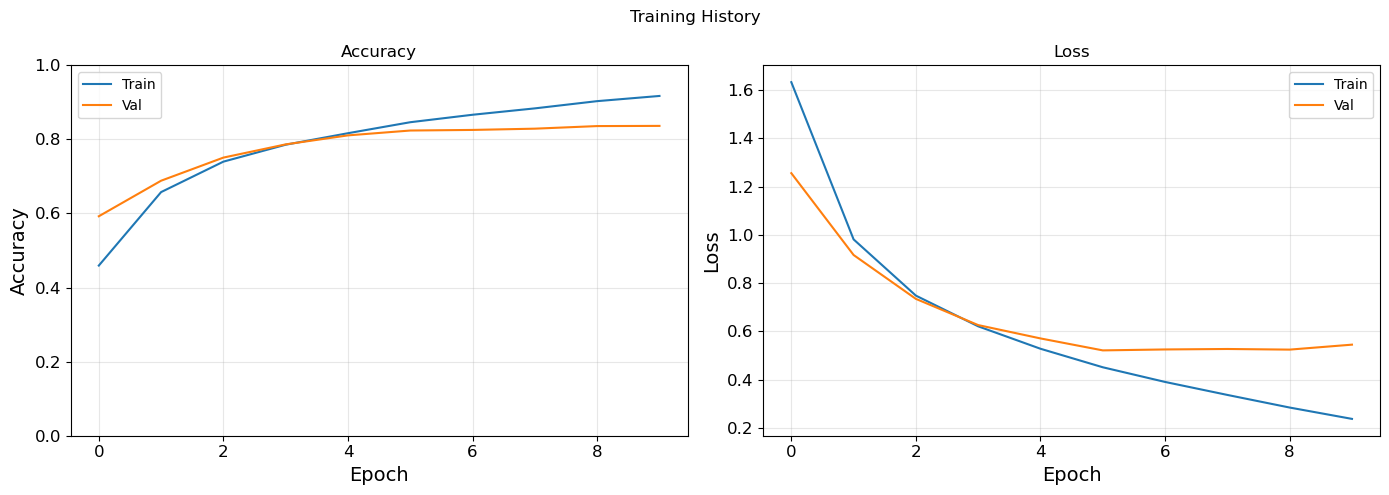

Loading model: /Users/homer/_mygit/project_module_2/saved_models/results/X_large/X_large_model.keras
Test Accuracy: 0.8296



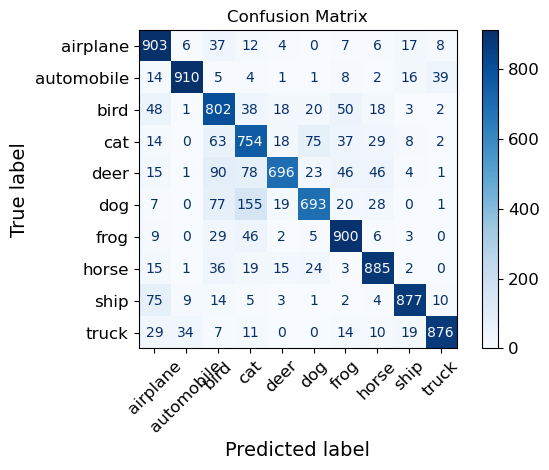

Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.90      0.85      1000
  automobile       0.95      0.91      0.93      1000
        bird       0.69      0.80      0.74      1000
         cat       0.67      0.75      0.71      1000
        deer       0.90      0.70      0.78      1000
         dog       0.82      0.69      0.75      1000
        frog       0.83      0.90      0.86      1000
       horse       0.86      0.89      0.87      1000
        ship       0.92      0.88      0.90      1000
       truck       0.93      0.88      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000


=== Processing: /Users/homer/_mygit/project_module_2/saved_models/results2/X_large ===


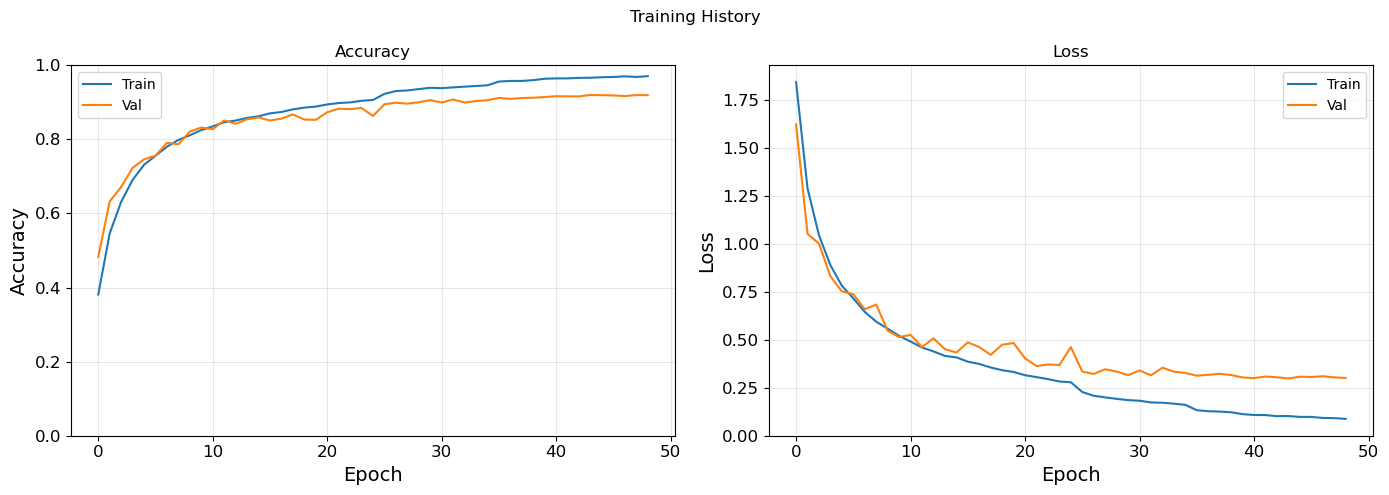

Loading model: /Users/homer/_mygit/project_module_2/saved_models/results2/X_large/X_large_model.keras
Test Accuracy: 0.9207



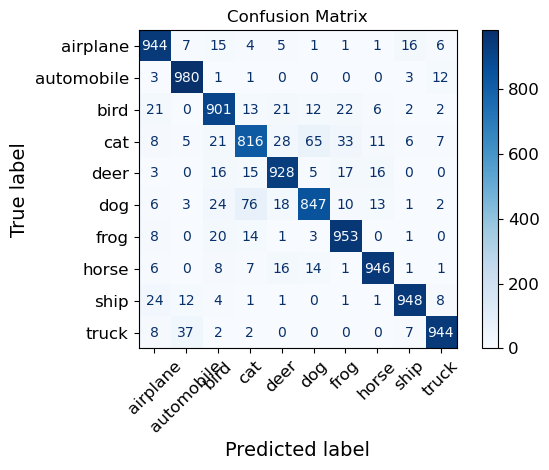

Classification Report:

              precision    recall  f1-score   support

    airplane       0.92      0.94      0.93      1000
  automobile       0.94      0.98      0.96      1000
        bird       0.89      0.90      0.90      1000
         cat       0.86      0.82      0.84      1000
        deer       0.91      0.93      0.92      1000
         dog       0.89      0.85      0.87      1000
        frog       0.92      0.95      0.94      1000
       horse       0.95      0.95      0.95      1000
        ship       0.96      0.95      0.96      1000
       truck       0.96      0.94      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


=== Processing: /Users/homer/_mygit/project_module_2/saved_models/resultgrid/f64-128-256__dense256__dr005-01-015-025__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none ===


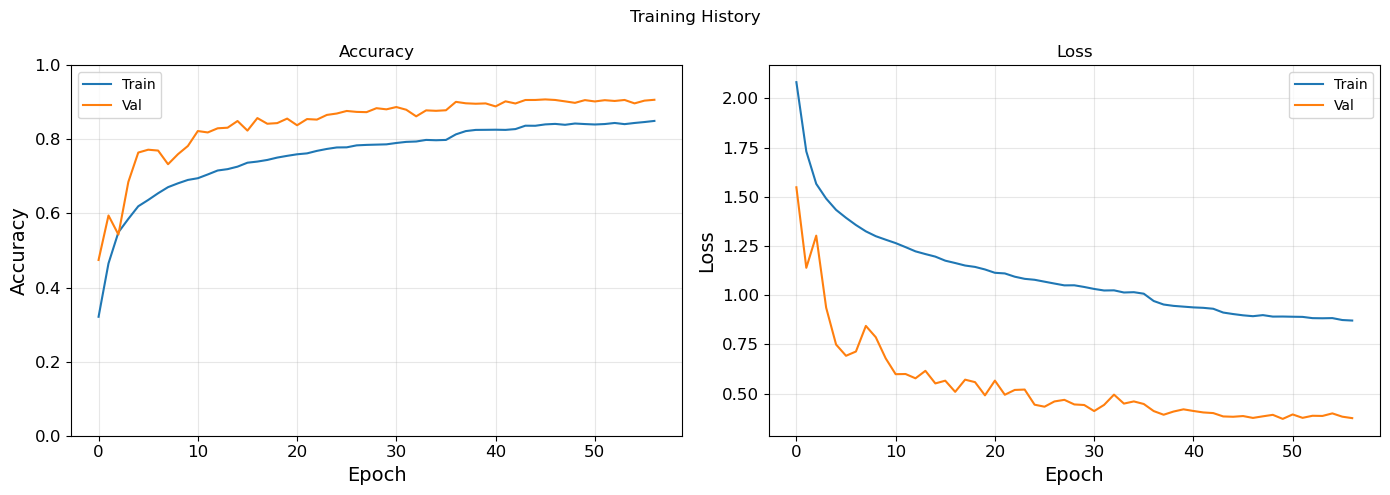

Loading model: /Users/homer/_mygit/project_module_2/saved_models/resultgrid/f64-128-256__dense256__dr005-01-015-025__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none/f64-128-256__dense256__dr005-01-015-025__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none_model.keras
Test Accuracy: 0.9015



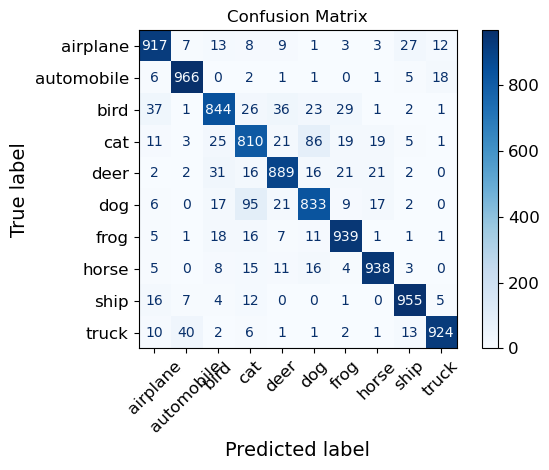

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.94      0.97      0.95      1000
        bird       0.88      0.84      0.86      1000
         cat       0.81      0.81      0.81      1000
        deer       0.89      0.89      0.89      1000
         dog       0.84      0.83      0.84      1000
        frog       0.91      0.94      0.93      1000
       horse       0.94      0.94      0.94      1000
        ship       0.94      0.95      0.95      1000
       truck       0.96      0.92      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
import os
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

import matplotlib.pyplot as plt

def plot_result(history, title="Training History"):
    """
    Plots Accuracy and Loss from either a dict (loaded JSON) 
    or a Keras History object.
    """
    # Handle dict vs. History object
    if isinstance(history, dict):
        acc = history.get("accuracy", [])
        val_acc = history.get("val_accuracy", [])
        loss = history.get("loss", [])
        val_loss = history.get("val_loss", [])
    else:  # History object from model.fit()
        acc = history.history.get("accuracy", [])
        val_acc = history.history.get("val_accuracy", [])
        loss = history.history.get("loss", [])
        val_loss = history.history.get("val_loss", [])

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    ax1.plot(acc, label="Train")
    ax1.plot(val_acc, label="Val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Loss plot
    ax2.plot(loss, label="Train")
    ax2.plot(val_loss, label="Val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Step : Load best data and display Accuracy/Loss plot / Confusion matrix / classification report

In [ ]:

def load_test_data(input_shape, num_classes):

    (_, _), (X_test, y_test) = cifar10.load_data()

    X_test = X_test.astype("float32") / 255.0

    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    return X_test, y_test, y_test_cat


# Directories with models
model_dirs = [
    "/Users/homer/_mygit/project_module_2/saved_models/results/X_large",
    "/Users/homer/_mygit/project_module_2/saved_models/results2/X_large",
    "/Users/homer/_mygit/project_module_2/saved_models/resultgrid/f64-128-256__dense256__dr005-01-015-025__optadam__lr5e-03__bs64__lrp5__minlr1e-07__L2none"
]

# CIFAR-10 has 10 classes
cifar10_class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

results_summary = {}

for model_dir in model_dirs:
    print(f"\n=== Processing: {model_dir} ===")

    # --- Try to plot training history if available ---
    history_file = None
    for f in os.listdir(model_dir):
        if f.endswith("_history.json") or f == "history.json":
            history_file = f
            break

    if history_file:
        history_path = os.path.join(model_dir, history_file)
        with open(history_path, "r") as f:
            history = json.load(f)
        plot_result(history)
    else:
        print("No history file found for plotting.")

    # --- Load Model & Evaluate ---
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.keras')]
    if model_files:
        # Pick most recent .keras file if multiple exist
        model_files.sort(key=lambda f: os.path.getmtime(os.path.join(model_dir, f)), reverse=True)
        model_path = os.path.join(model_dir, model_files[0])

        print(f"Loading model: {model_path}")
        model = load_model(model_path)

        input_shape = model.input_shape[1:]
        num_classes = model.output_shape[-1]

        # Load CIFAR-10 test data
        X_test, y_true, y_test_cat = load_test_data(input_shape, num_classes)

        # Evaluate and report
        metrics = evaluate_and_report(model, X_test, y_test_cat, cifar10_class_names)
        results_summary[os.path.basename(model_dir)] = metrics
    else:
        print("No .keras model file found.")

